# Sentiment

Visualize sentiment analysis

In [2]:
import datetime
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
DATADIRECTORYALL = "../data/sentiment/ALL-pattern/"
DATADIRECTORYRIVM = "../data/sentiment/rivm-pattern/"
DATADIRECTORYTEXT = "../data/text/"
SENTIMENT = "sentiment"
COUNT = "count"
DATA = "data"
LABEL = "label"
HIGHLIGHT = "highlight"
HIGHLIGHTLABEL = "highlightlabel"

## Read hourly sentiment analysis by pattern's sentiment analysis

In [4]:
def getSentimentPerHour(dataDirectory):
    fileList = os.listdir(dataDirectory)
    sentimentPerHour = {}
    for inFileName in fileList:
        if re.search(r"2*z",inFileName):
            try: df = pd.read_csv(dataDirectory+inFileName,compression="gzip",header=None)
            except: continue
            sentiment = sum(df[1])/len(df)
            hour = inFileName[0:11]
            sentimentPerHour[hour] = { SENTIMENT:sentiment, COUNT:len(df) }
    sentimentPerHour = {key:sentimentPerHour[key] for key in sorted(sentimentPerHour.keys())}
    return(sentimentPerHour)

## Convert hourly analysis to day scores

In [5]:
def makeSentimentPerDay(sentimentPerHour):
    sentimentPerDay = {}
    for hour in sentimentPerHour:
        day = re.sub("..$","12",hour)
        if not day in sentimentPerDay: sentimentPerDay[day] = {SENTIMENT:0,COUNT:0}
        sentimentPerDay[day][SENTIMENT] += sentimentPerHour[hour][SENTIMENT]*sentimentPerHour[hour][COUNT]
        sentimentPerDay[day][COUNT] += sentimentPerHour[hour][COUNT]
    for day in sentimentPerDay:
        sentimentPerDay[day][SENTIMENT] /= sentimentPerDay[day][COUNT]
    return(sentimentPerDay)

## Visualize

In [6]:
DATEFORMATHOUR = "%Y%m%d-%H"
DEFAULTTITLE = "Sentiment scores of Dutch tweets over time"

def visualizeSentiment(dataSources,title=DEFAULTTITLE):
    fig,ax = plt.subplots(figsize=(9,4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
    for i in range(0,len(dataSources)):
        data = dataSources[i][DATA]
        label = dataSources[i][LABEL]
        lineData= ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in data],\
                     [data[key][SENTIMENT] for key in data],xdate=True,fmt="-",label=label)
        if HIGHLIGHT in dataSources[i]:
            highlight = dataSources[i][HIGHLIGHT]
            highlightlabel = dataSources[i][HIGHLIGHTLABEL]
            color = lineData[-1].get_color()
            ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in highlight],
                         [data[key][SENTIMENT] for key in highlight],\
                         fmt="o",color=color,label=highlightlabel)
                
    plt.title(title)
    plt.legend(framealpha=0.2)
    plt.show()
    return(ax)

## Process data obtained from all Dutch tweets

In [7]:
%matplotlib notebook

highlight = ["20200312-12","20200315-12","20200317-12","20200319-12","20200323-12","20200331-12","20200407-12",\
             "20200415-12","20200421-12","20200429-12","20200506-12","20200513-12"]

sentimentPerHour = getSentimentPerHour(DATADIRECTORYALL)
sentimentPerDay = makeSentimentPerDay(sentimentPerHour)
dummy = visualizeSentiment([{DATA:sentimentPerHour,LABEL:"per hour"},
                            {DATA:sentimentPerDay,LABEL:"per day",\
                             HIGHLIGHT:highlight,HIGHLIGHTLABEL:"press conference"}],\
                           title=DEFAULTTITLE+" (all Dutch tweets)")

<IPython.core.display.Javascript object>

/home/erikt/anaconda3/envs/python37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


## Visualize sentiment of single press conference day

<IPython.core.display.Javascript object>


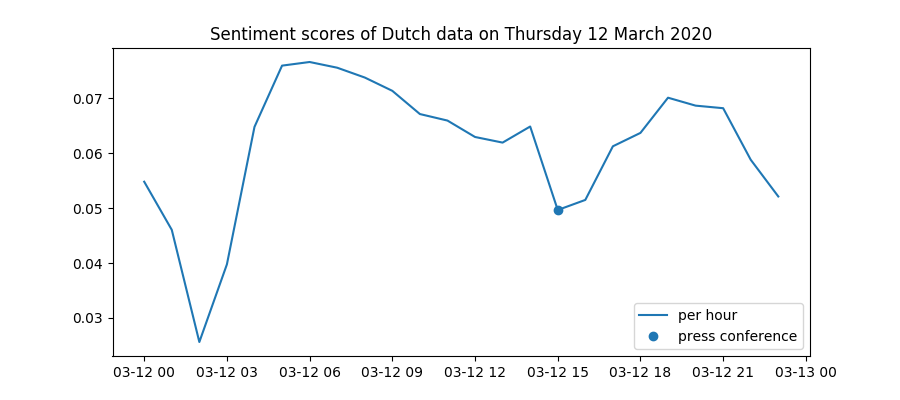

In [7]:
dummy = visualizeSentiment([{DATA:{k:sentimentPerHour[k] for k in sentimentPerHour.keys() \
                                   if re.search(r"^20200312",k)},\
                             LABEL:"per hour",HIGHLIGHT:["20200312-15"],HIGHLIGHTLABEL:"press conference"}],\
                           title="Sentiment scores of Dutch data on Thursday 12 March 2020")

## Compare day graph with previous years

<IPython.core.display.Javascript object>


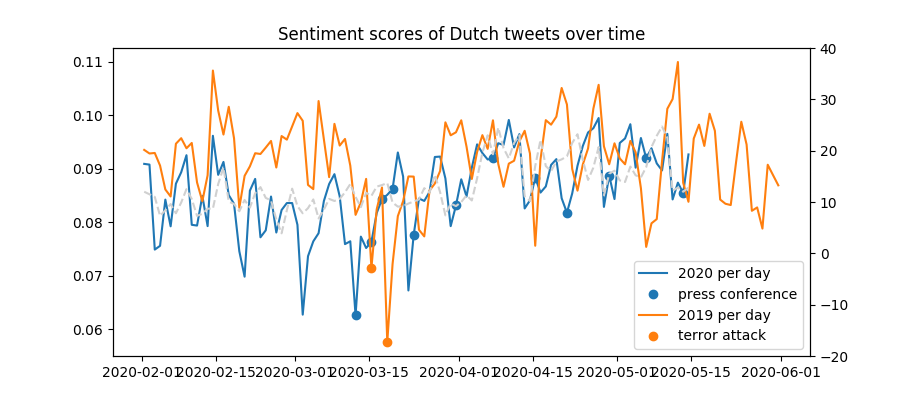

In [11]:
DATADIRECTORYALL2019 = "../data/sentiment/2019/"
TEMPERATURESFILE = "../data/temperatures.csv" 

def changeYearTo2020(dataIn):
    dataOut = {}
    for dateString in dataIn:
        dateString2020 = re.sub(r"20[0-9][0-9]","2020",dateString)
        dataOut[dateString2020] = dataIn[dateString]
    return(dataOut)

sentimentPerHour2019 = getSentimentPerHour(DATADIRECTORYALL2019)
sentimentPerDay2019 = makeSentimentPerDay(sentimentPerHour2019)
ax = visualizeSentiment([{DATA:sentimentPerDay,LABEL:"2020 per day",\
                          HIGHLIGHT:highlight,HIGHLIGHTLABEL:"press conference"},\
                         {DATA:changeYearTo2020(sentimentPerDay2019),LABEL:"2019 per day",\
                          HIGHLIGHT:["20200315-12","20200318-12"],HIGHLIGHTLABEL:"terror attack"}],
                         title=DEFAULTTITLE)

## Add daily temperatures to plot

In [12]:
def readTemperatures():
    temperatures = pd.read_csv(TEMPERATURESFILE,header=None)
    temperatures = { (str(temperatures[0][i])+"-12"):(temperatures[1][i]/10) for i in range(0,len(temperatures))}
    return(temperatures)

temperatures = readTemperatures()

ax2 = ax.twinx()
ax2.set_ylim([-20,40])
dummy = ax2.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in temperatures],\
                      [temperatures[key] for key in temperatures],xdate=True,\
                      fmt="--",color="990000",label="temperature")

## Check relation temperature - sentiment

<IPython.core.display.Javascript object>


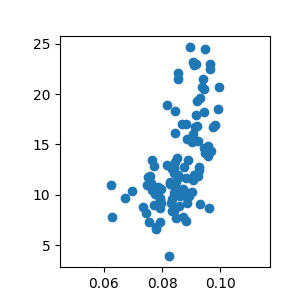

In [13]:
plt.figure(figsize=(3,3))
plt.gcf().subplots_adjust(left=0.2)
x = [sentimentPerDay[key][SENTIMENT] for key in temperatures]
y = [temperatures[key] for key in temperatures]
plt.scatter(x,y)
plt.show()

In [16]:
np.corrcoef(x,y)[0][1]

0.5539185771840645

## Check relation sentiment today - yesterday 

<IPython.core.display.Javascript object>


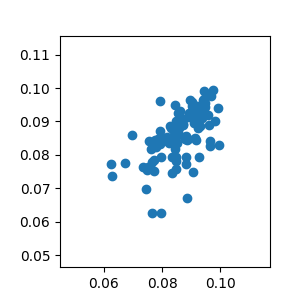

In [17]:
plt.figure(figsize=(3,3))
plt.gcf().subplots_adjust(left=0.2)
x = [sentimentPerDay[key][SENTIMENT] for key in sentimentPerDay]
y = [sentimentPerDay[key][SENTIMENT] for key in sentimentPerDay]
x.pop(-1)
y.pop(0)
plt.scatter(x,y)
plt.show()

In [18]:
np.corrcoef(x,y)[0][1]

0.5892901816105046

## Sort days by sentiment score

Dates of Dutch government press conferences related to corona crisis:

1. Thursday 12 March 2020: https://www.youtube.com/watch?v=0iD1FN6I87Y (start: around 15:15 PM)
2. Sunday 15 March 2020: https://www.youtube.com/watch?v=j94ULn90xg8
3. Tuesday 17 March 2020: https://www.youtube.com/watch?v=KuXj3c1F8WY
4. Thursday 19 March 2020: https://www.youtube.com/watch?v=Yqx0PlSnUFE
5. Monday 23 March 2020: https://www.youtube.com/watch?v=mcpLFX_L9o8
6. Tuesday 31 March 2020: https://www.youtube.com/watch?v=FNuzw3wplow
7. Tuesday 7 April 2020: https://www.youtube.com/watch?v=-j3_mmZcBZU
8. Wednesday 15 April 2020: https://www.youtube.com/watch?v=n1-rSb3j0UM
9. Tuesday 21 April 2020: https://www.youtube.com/watch?v=Yjx7SPtq7Bk
10. Wednesday 29 April 2020: https://www.youtube.com/watch?v=dfhzIGagbOw
11. Wednesday 6 May 2020: https://www.youtube.com/watch?v=rBtDphRcPKA
12. Wednesday 13 May 2020: https://www.youtube.com/watch?v=zISG9KkuAQ0

In [19]:
{k:round(v[SENTIMENT],4) for k,v in sorted(sentimentPerDay.items(),key=lambda item:item[1][SENTIMENT])}

{'20200312-12': 0.0626,
 '20200302-12': 0.0627,
 '20200322-12': 0.0672,
 '20200220-12': 0.0698,
 '20200303-12': 0.0736,
 '20200219-12': 0.0746,
 '20200203-12': 0.0749,
 '20200314-12': 0.0752,
 '20200204-12': 0.0756,
 '20200310-12': 0.0759,
 '20200315-12': 0.0763,
 '20200304-12': 0.0764,
 '20200311-12': 0.0764,
 '20200223-12': 0.0772,
 '20200313-12': 0.0773,
 '20200323-12': 0.0776,
 '20200305-12': 0.0779,
 '20200226-12': 0.0781,
 '20200224-12': 0.0785,
 '20200206-12': 0.0792,
 '20200330-12': 0.0792,
 '20200213-12': 0.0793,
 '20200211-12': 0.0794,
 '20200301-12': 0.0795,
 '20200210-12': 0.0795,
 '20200316-12': 0.0817,
 '20200421-12': 0.0818,
 '20200227-12': 0.0823,
 '20200413-12': 0.0826,
 '20200428-12': 0.0829,
 '20200331-12': 0.0831,
 '20200218-12': 0.0834,
 '20200229-12': 0.0836,
 '20200228-12': 0.0836,
 '20200306-12': 0.0839,
 '20200325-12': 0.084,
 '20200414-12': 0.0841,
 '20200205-12': 0.0842,
 '20200511-12': 0.0842,
 '20200317-12': 0.0843,
 '20200430-12': 0.0843,
 '20200324-12': 0

## Process data from RIVM query

<IPython.core.display.Javascript object>


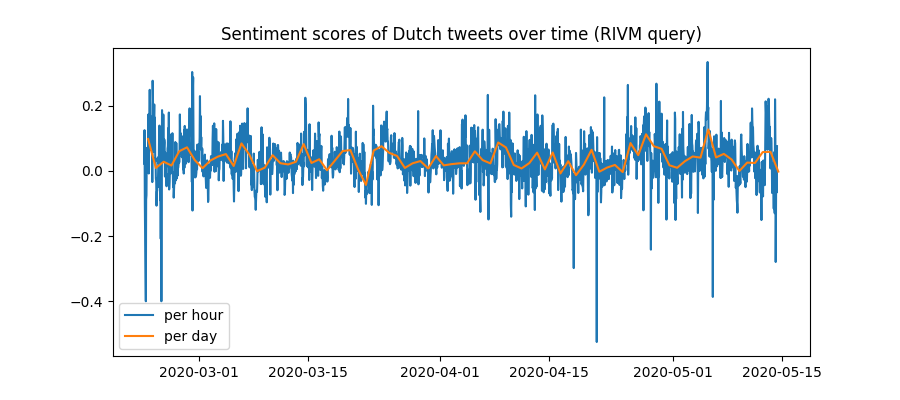

In [20]:
sentimentPerHour = getSentimentPerHour(DATADIRECTORYRIVM)
sentimentPerDay = makeSentimentPerDay(sentimentPerHour)
visualizeSentiment([{DATA:sentimentPerHour,LABEL:"per hour"},{DATA:sentimentPerDay,LABEL:"per day"}],\
                   title=DEFAULTTITLE+" (RIVM query)")

## Sort days by sentiment score

In [21]:
{k:v for k,v in sorted(sentimentPerDay.items(),key=lambda item:item[1][SENTIMENT])}

{'20200322-12': {'sentiment': -0.04297012630880684, 'count': 8637},
 '20200418-12': {'sentiment': -0.01314631195945318, 'count': 3964},
 '20200416-12': {'sentiment': -0.0077987618522368015, 'count': 5685},
 '20200424-12': {'sentiment': -0.0035841825018657386, 'count': 2731},
 '20200421-12': {'sentiment': -0.002453768637961215, 'count': 5276},
 '20200514-12': {'sentiment': -0.0020622697204521136, 'count': 223},
 '20200308-12': {'sentiment': -0.0007267400880460683, 'count': 3768},
 '20200509-12': {'sentiment': -0.000319871026704408, 'count': 2841},
 '20200317-12': {'sentiment': 0.0018961155003085271, 'count': 10474},
 '20200321-12': {'sentiment': 0.004071142643697075, 'count': 7353},
 '20200414-12': {'sentiment': 0.004631946169418988, 'count': 2944},
 '20200411-12': {'sentiment': 0.007448706110406927, 'count': 2638},
 '20200330-12': {'sentiment': 0.007678586780335376, 'count': 6736},
 '20200301-12': {'sentiment': 0.008460195459694607, 'count': 4472},
 '20200327-12': {'sentiment': 0.00910

## Examine tweet texts from day with extreme sentiment

In [ ]:
import gzip
import json
import numpy as np
from library import getTweetText

def removeNewlines(text):
    return(re.sub(r"\n",r" ",text))

HOURSPERDAY = 24
DATE = "20200302"
TWEETDIRECTORYRIVM = "../data/rivm/"

tweetTexts = []
for hour in range(0,HOURSPERDAY):
    hour = str(hour).zfill(2)
    inFile = gzip.open(TWEETDIRECTORYRIVM+DATE+"-"+hour+".rivm.gz")
    for line in inFile:
        jsonData = json.loads(line)
        tweetText = removeNewlines(getTweetText(jsonData))
        tweetTexts.append(tweetText)
    inFile.close()
    
pd.DataFrame(tweetTexts)[0].value_counts()[0:20]

## Process sentiment of topic

In [8]:
def readSentiment(fileName):
    return(pd.read_csv(fileName,index_col="date").T.to_dict())

In [10]:
DATADIR = "../data/sentiment/"
TOPIC = "corona|covid|flattenthecurve|blijfthuis|rivm|mondkapje|huisarts|houvol|zorg"
EXTENSION = ".csv"

sentimentPerHourTopic = readSentiment(DATADIR+TOPIC+EXTENSION)

In [11]:
sentimentPerDayTopic = makeSentimentPerDay(sentimentPerHourTopic)
dummy = visualizeSentiment([{DATA:sentimentPerDay,LABEL:"all",
                            HIGHLIGHT:highlight,HIGHLIGHTLABEL:"press conference"},
                            {DATA:sentimentPerDayTopic,LABEL:"topic",\
                             HIGHLIGHT:highlight,HIGHLIGHTLABEL:"press conference"}],\
                           title=DEFAULTTITLE+" (all Dutch tweets vs topic tweets)")

<IPython.core.display.Javascript object>

In [32]:
for selectedDates in "202002 202003 202004 202005[01]".split():
    nbrOfTweetsAll = sum([sentimentPerDay[date][COUNT] for date in sentimentPerDay if re.search(selectedDates,date)])
    nbrOfTweetsTopic = sum([sentimentPerDayTopic[date][COUNT] for date in sentimentPerDayTopic if re.search(selectedDates,date)])
    print(selectedDates,round(nbrOfTweetsTopic/nbrOfTweetsAll,3))

202002 0.039
202003 0.174
202004 0.138
202005[01] 0.094
